In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import math
import IPython.display as ipd

In [3]:
audio_path = r'dataset/raw/2473663/2243804495.mp3'

In [4]:
window_size = 2048
step_size = 512
sample_rate = 44100
filter_banks = 128
freq_max = 10000

In [5]:
#split a time series into multiple frames given a window size and step size
def get_even_time_series_frames(time_series : np.array, window_size : int, step_size : int):
    #calculate number of frames (has to be an even number?)
    frame_num = (len(time_series) - window_size)/step_size + 1
    series = time_series #copy series
    if frame_num % 2 != 0:  #ensure that number of frames is a even number
        frame_num = math.ceil(frame_num / 2.0) * 2 #round number of frames to even number
        padding_len = (frame_num - 1) * step_size + window_size - len(time_series)  #calculate padding length 
        series = np.pad(series, (0, padding_len), 'constant') #pad end of series with 0s
    frame_num = int(frame_num)
    #create and return frames from rime series 
    return np.array([ series[step*step_size:step*step_size+window_size] for step in range(frame_num)])

In [6]:
#convert frequency to mel scale
def frequency_to_mel(freq):
    return 2595 * np.log10(1 + freq / 700)

#convert mel to frequency
def mel_to_frequency(mel):
    return 700 * (10 **(mel / 2595) - 1)

In [7]:
def create_filter_bank(sample_rate, n_fft, n_filters, freq_min = 0, freq_max = 22050):
    #convert min and max frequency to mel scale
    min_mel = frequency_to_mel(freq_min)
    max_mel = frequency_to_mel(freq_max)
    #create linearly spaced points between the min and max mel
    mel_points = np.linspace(min_mel, max_mel, n_filters + 2)
    #print(mel_points)    
    #convert mel points back to hz
    freq_points = mel_to_frequency(mel_points)
    #print(freq_points)
    #round frequency points to nearest fourier transform bin (n_fft)

    freq_bins = np.floor((n_fft + 1) * freq_points / sample_rate).astype(int)
    
    print(freq_bins)

    fbank = np.zeros((n_filters, int(np.floor(n_fft / 2) + 1)))

    for m in range(1, n_filters + 1):
        filter_bank_start = freq_bins[m - 1]
        filter_bank_max   = freq_bins[m]
        filter_bank_end   = freq_bins[m + 1]

        filter_len = filter_bank_end - filter_bank_start
        for k in range(filter_bank_start, filter_bank_max):
            #print(k)
            fbank[m - 1, k] = (k - freq_bins[m - 1]) / (freq_bins[m] - freq_bins[m - 1])
        for k in range(filter_bank_max, filter_bank_end):
            fbank[m - 1, k] = (freq_bins[m + 1] - k) / (freq_bins[m + 1] - freq_bins[m])

        fbank[m-1] /= filter_len

    return fbank

In [8]:
def draw_spectogram(spectogram_matrix):
    f = plt.figure(figsize=(10,5), dpi= 80)
    ax = f.add_subplot()
    ax.set_title('Mel-frequency spectrogram') #set title 
    mfcc = ax.matshow(spectogram_matrix, aspect="auto", cmap=plt.get_cmap('magma')) #draw matrix with colormap 'magma'
    ax.xaxis.set_ticks_position('bottom') #set x ticks to bottom of graph 
    ax.set_xlabel('Time (sec)')
    ax.invert_yaxis() #have y axis start from the bottom
    ax.set_ylabel('Hz')
    plt.tight_layout()
    plt.colorbar(mfcc, format='%+2.0f dB');
    plt.show()

In [9]:
#sample audio at 44.1 khz and get the time series as a numpy array
time_series, sample_rate = librosa.load(audio_path, sr = sample_rate)
#trim empty start and end padding from time series
time_series, _ = librosa.effects.trim(time_series)

In [10]:
time_series_frames = get_even_time_series_frames(time_series, 2048, 512)

In [11]:
lib_frames = librosa.util.frame(time_series, 2048, 512)
lib_frames = lib_frames.T

In [12]:
print((lib_frames == time_series_frames).all())
print(np.array_equal(lib_frames, time_series_frames))
print('librosa: {} own: {}'.format(lib_frames.shape, time_series_frames.shape))

True
True
librosa: (1158, 2048) own: (1158, 2048)


In [13]:
windowed_frames = time_series_frames * np.hanning(window_size)

In [14]:
lib_windowed_frames = lib_frames * np.hanning(window_size)

In [15]:
mag_frames = np.abs(np.fft.rfft(windowed_frames, 2048))
pow_frames = ((1.0 / 2048) * ((mag_frames) ** 2))



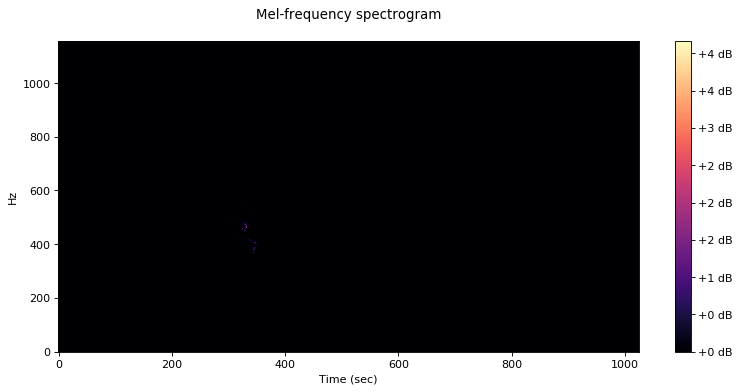

In [16]:
draw_spectogram(pow_frames.T)

In [17]:
lib_mag_frames = np.abs(np.fft.rfft(lib_windowed_frames, 2048))
lib_pow_frames = ((1.0 / 2048) * ((lib_mag_frames) ** 2))

In [18]:
mel = librosa.filters.mel(sr=16000, n_fft=512, n_mels=10, fmin = 300, fmax=8000, htk = True)
print(mel.shape)
mel[0][:8 * 5]


(10, 257)


array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 2.38693596e-04, 8.35427549e-04,
       1.43216155e-03, 2.02889554e-03, 2.62562954e-03, 3.22236354e-03,
       3.81909753e-03, 3.93191446e-03, 3.44171841e-03, 2.95152212e-03,
       2.46132608e-03, 1.97112979e-03, 1.48093363e-03, 9.90737462e-04,
       5.00541297e-04, 1.03451075e-05, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
      dtype=float32)

In [19]:
own_mel = create_filter_bank(16000, n_fft=512, n_filters=10, freq_min = 300, freq_max=8000)
print(own_mel.shape)
#print(np.fft.rfftfreq(2048, d=1/16000))
own_mel[0][:8*5]

[  9  16  25  35  47  63  81 104 132 165 206 256]
(10, 257)


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.00892857, 0.01785714, 0.02678571, 0.03571429, 0.04464286,
       0.05357143, 0.0625    , 0.05555556, 0.04861111, 0.04166667,
       0.03472222, 0.02777778, 0.02083333, 0.01388889, 0.00694444,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

In [20]:
mel = librosa.filters.mel(sr=sample_rate, n_fft=window_size, n_mels=filter_banks, fmax=freq_max)
own_mel = create_filter_bank(sample_rate, n_fft=window_size, n_filters=filter_banks, freq_max=freq_max)
own_mel = librosa.filters.mel(sr=sample_rate, n_fft=window_size, n_mels=filter_banks, fmax=freq_max, htk = True)


[  0   0   1   2   2   3   4   5   5   6   7   8   9  10  11  12  13  14
  15  16  17  18  19  20  21  22  23  25  26  27  28  30  31  32  34  35
  37  38  40  41  43  44  46  48  49  51  53  55  57  59  61  63  65  67
  69  71  73  75  78  80  83  85  88  90  93  95  98 101 104 107 110 113
 116 119 122 126 129 133 136 140 143 147 151 155 159 163 167 172 176 180
 185 190 194 199 204 209 214 220 225 231 236 242 248 254 260 266 273 279
 286 293 300 307 314 321 329 337 345 353 361 369 378 387 396 405 414 424
 434 444 454 464]


In [21]:

mel_scale_frames = np.dot(pow_frames, own_mel.T)
mel_scale_frames = np.where(mel_scale_frames == 0, np.finfo(float).eps, mel_scale_frames)

In [22]:
lib_mel_scale_frames = mel.dot(lib_pow_frames.T)

In [23]:
np.array_equal(mel_scale_frames, lib_mel_scale_frames)

False

In [24]:
db_scale_frames = librosa.power_to_db(mel_scale_frames, ref=np.max)

In [25]:
lib_db_scale_frames = librosa.power_to_db(lib_mel_scale_frames, ref=np.max)

In [26]:
rot_db_scale_frames = db_scale_frames.T
print(rot_db_scale_frames.shape)
print(db_scale_frames.shape)

(128, 1158)
(1158, 128)


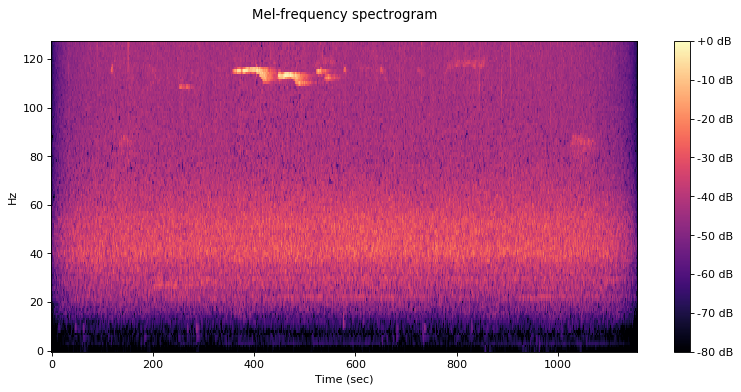

In [27]:
draw_spectogram(rot_db_scale_frames)

In [28]:
mean = db_scale_frames.mean(axis = 0).shape

In [29]:
reconstructed_time_series = librosa.feature.inverse.mel_to_audio(lib_mel_scale_frames, sr = sample_rate, n_fft= window_size, hop_length= step_size, center= False)



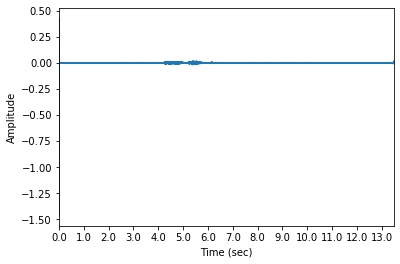

In [30]:
fig, main_ax = plt.subplots()
main_ax.plot(reconstructed_time_series[:len(time_series) - 10])
main_ax.set_xlim(left = 0, right = len(time_series))
main_ax.set_xticks(np.arange(0, len(time_series), step = sample_rate))
main_ax.set_xticklabels(np.arange(0, len(time_series) / sample_rate))
main_ax.set_xlabel('Time (sec)')
main_ax.set_ylabel('Amplitude')
plt.show()

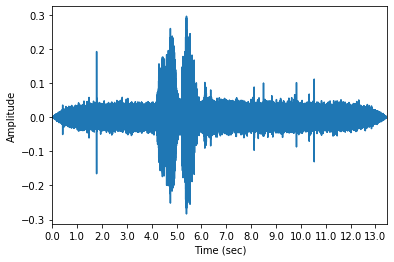

In [31]:
fig, main_ax = plt.subplots()
main_ax.plot(time_series)
main_ax.set_xlim(left = 0, right = len(time_series))
main_ax.set_xticks(np.arange(0, len(time_series), step = sample_rate))
main_ax.set_xticklabels(np.arange(0, len(time_series) / sample_rate))
main_ax.set_xlabel('Time (sec)')
main_ax.set_ylabel('Amplitude')
plt.show()

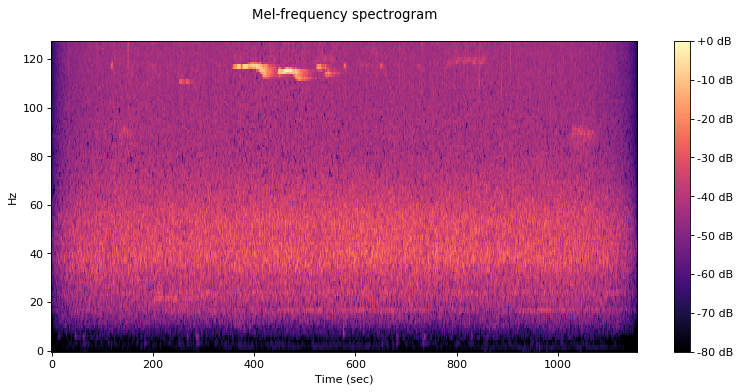

In [32]:
draw_spectogram(lib_db_scale_frames)

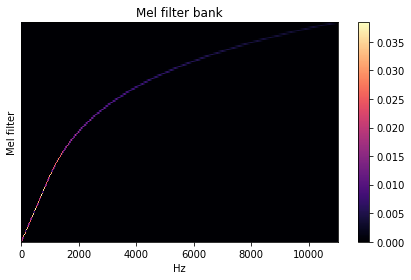

In [33]:
melfb = librosa.filters.mel(22050, n_fft = 2048, n_mels = 128, fmax = 22050/2.0)
plt.figure()
librosa.display.specshow(melfb, x_axis='linear')
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()
plt.show()

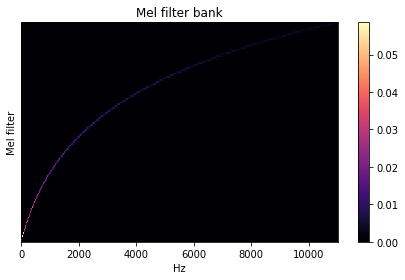

In [31]:
melfb = librosa.filters.mel(22050, n_fft = 2048, n_mels = 128, fmax = 22050/2.0, htk = True)
plt.figure()
librosa.display.specshow(melfb, x_axis='linear')
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()
plt.show()

[   0    1    2    4    5    7    9   10   12   14   15   17   19   21
   23   25   27   29   31   33   35   37   40   42   44   47   49   52
   54   57   60   63   65   68   71   74   77   80   84   87   90   94
   97  101  105  108  112  116  120  124  128  133  137  142  146  151
  156  160  165  171  176  181  187  192  198  204  210  216  222  228
  235  241  248  255  262  269  277  284  292  300  308  316  325  333
  342  351  360  370  379  389  399  409  420  431  442  453  464  476
  488  500  513  525  538  552  565  579  594  608  623  638  654  670
  686  703  720  737  755  773  791  810  830  849  869  890  911  933
  955  977 1000 1024]


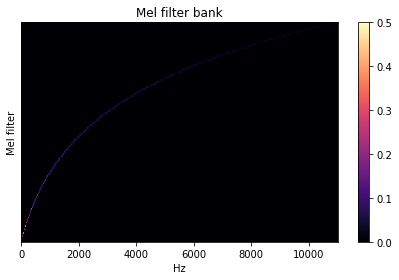

In [32]:
own_melfb = create_filter_bank(22050, n_fft=2048, n_filters=128, freq_max=22050/2.0)
plt.figure()
librosa.display.specshow(own_melfb, x_axis='linear')
plt.ylabel('Mel filter')
plt.title('Mel filter bank')
plt.colorbar()
plt.tight_layout()
plt.show()